In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.svm import SVC


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

github link: https://github.com/colites/AI-differentiation

The purpose of this project is to be able to classify between AI generated texts and human-made text. This is an important topic, especially with the rapid rise of LLM usage. Being able to determine whether text is AI generated would help prevent people from getting tricked, which is useful for not allowing malevolent actors from spreading misinformation through AI generated text. It is also important for schooling since with AI generated text, it is easier to be able to generate essays and cheat through classes that depend on assignments like essays.

This project will use two different datasets filled with AI generated text and human-made text for robust training. These texts in the datasets were written based on prompts given to both the AI and the human beings. The training sets contain texts and prompts along with the labels assigned to them. The test set does not have labels because they will be predicted using the fitted model and then submitted for review.

The main type of model that will be used to classify the texts will be a RNN architecture based model, which is a deep learning model that is used for time series or sequential data. This project will also, in addition to training the RNN, train both an unsupervised and supervised model to compare performance with the RNN based model. 

To begin, we will do basic exploratory data analysis on both datasets before merging them. We will not do data cleaning until the datasets have been merged.

In [5]:
## load in the datssets
train_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

extra_train_data = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

In [6]:
train_data.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
train_data.info()
print(f'The data types for the table are: {train_data.dtypes}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
The data types for the table are: id           object
prompt_id     int64
text         object
generated     int64
dtype: object


In [5]:
train_data.describe()

,prompt_id,generated
count,1378.000000,1378.000000
mean,0.486212,0.002177
std,0.499991,0.046625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [6]:
extra_train_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [7]:
print(f'The data types for the table are: {extra_train_data.dtypes}')
extra_train_data.info()

The data types for the table are: text             object
label             int64
prompt_name      object
source           object
RDizzl3_seven      bool
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


generated
0    1375
1       3
Name: count, dtype: int64


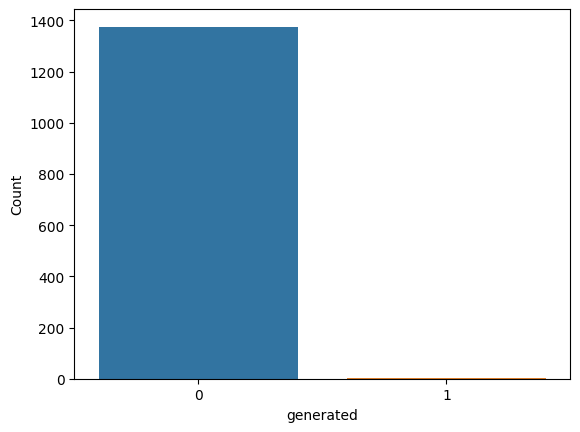

In [7]:
## Check to see how many texts are AI-generated
## 0 is made by a human, 1 is AI-generated
print(train_data['generated'].value_counts())
generated_counts = train_data['generated'].value_counts().reset_index()
generated_counts.columns = ['generated', 'Count']

ax = sns.barplot(x='generated', y='Count', data=generated_counts)

One very important piece of information to note above is that there are only 3 AI generated pieces of text in the training data. This means that all the labels are skewed heavily, almost entirely, to human made texts. This means that most models will have a hard time generalizing the data, since the data is very heavily skewed towards one class label. Many models will just default to choosing the majority class, since the other class is so small. 

To rectify this situation, we will combine the daigt dataset with the competition dataset. This will solve the class imbalance and give a much greater sample of AI generated texts for the deep learning model to train on. Without it, heavy manual feature engineering would be needed to make most models give any meaningful label predictions. Adding the extra dataset will remove the need for more substantial feature engineering. The data cleaning will be done after combining both datasets to avoid having to do it for both individual datasets. It also avoids having to do extra data cleaning after merging, since merging can create null values.

Since the merging will give null values for all the columns in train_data that do not exist in the extra_train_data dataset, this means that the only columns that will stay are the ones that both share, which are the text and label columns. The columns that were not shared among both datasets will be dropped. They will be dropped before the merging to speed the up the process, which can take long in larger datasets.

The combination of both sets of data is done below.

In [8]:
## Get rid of extra columns and rename to be the same to train_data
extra_train_data.rename({'label': 'generated'},axis=1, inplace=True)
extra_train_data.drop(['source', 'RDizzl3_seven', 'prompt_name'], axis=1, inplace=True)
extra_train_data.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [9]:
train_data.drop(['prompt_id', 'id'], axis=1, inplace=True)
train_data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [10]:
## merge both dataframes
merged_df = pd.merge(train_data, extra_train_data, how='outer')
merged_df.head()

,text,generated
0,\nBeing a Seagoing Cowboy opened my eyes to in...,1
1,\nBoth teacher-designed and student-designed s...,1
2,\nBoth teacher-designed and student-designed s...,1
3,"\nDear Principal Johnson, \n\nI am writing reg...",1
4,"\nDear Principal Johnson, \n\nI am writing reg...",1


generated
0    27371
1    17497
Name: count, dtype: int64


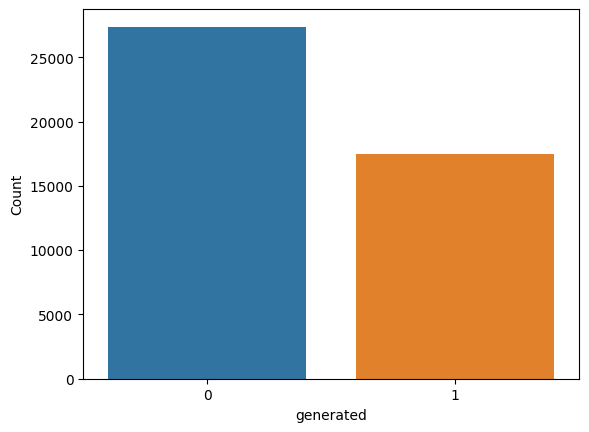

In [12]:
## Check to see how many texts are AI-generated
## 0 is made by a human, 1 is AI-generated
print(merged_df['generated'].value_counts())
generated_counts = merged_df['generated'].value_counts().reset_index()
generated_counts.columns = ['generated', 'Count']

ax = sns.barplot(x='generated', y='Count', data=generated_counts)

With both dataframes merged into one, the classes are now more balanced. Now there are numerous samples for the AI generated texts and a much greater total number of training samples from both classes. This will help train a better model, since there will be more samples for it to learn from.

Now we can begin to do data cleaning, which will consist of dropping duplicates if they exist and dropping any rows that have null values. There needs to be no invalid values for the models to be able to train correctly. 

In [11]:
#find the number of duplicates in the training data
duplicates = merged_df.duplicated().sum()
print(duplicates)

0


In [12]:
missing_values_count = merged_df.isnull().sum()
print(f' The number of missing values is :{missing_values_count}')

 The number of missing values is :text         0
generated    0
dtype: int64


In [15]:
missing_values_count_test = test_data.isnull().sum()
print(f' The number of missing values is :{missing_values_count_test}')

 The number of missing values is :id           0
prompt_id    0
text         0
dtype: int64


In [13]:
merged_df['text_length'] = merged_df['text'].apply(len)
merged_df['word_count']= merged_df['text'].apply(lambda x: len(x.split()))
merged_df.head()

,text,generated,text_length,word_count
0,\nBeing a Seagoing Cowboy opened my eyes to in...,1,1866,315
1,\nBoth teacher-designed and student-designed s...,1,2109,301
2,\nBoth teacher-designed and student-designed s...,1,1989,306
3,"\nDear Principal Johnson, \n\nI am writing reg...",1,1694,263
4,"\nDear Principal Johnson, \n\nI am writing reg...",1,1860,278


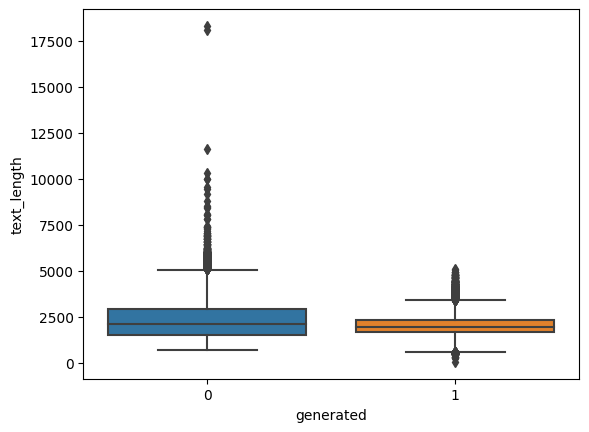

In [17]:
ax2 = sns.boxplot(x='generated', y='text_length', data=merged_df)

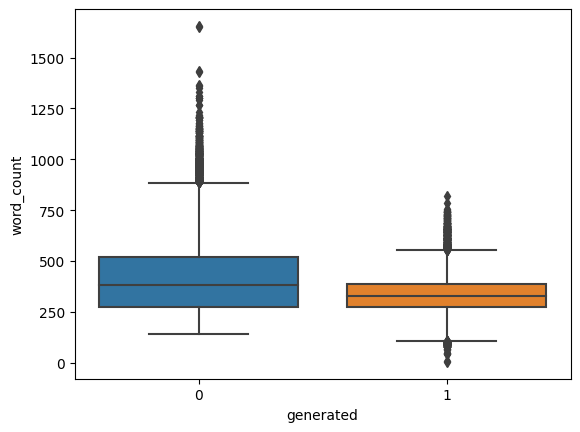

In [18]:
ax2 = sns.boxplot(x='generated', y='word_count', data=merged_df)

In [14]:
ai_generated_texts = merged_df[merged_df['generated'] == 1]
ai_generated_text_contents = ai_generated_texts['text']
print(ai_generated_text_contents)

0        \nBeing a Seagoing Cowboy opened my eyes to in...
1        \nBoth teacher-designed and student-designed s...
2        \nBoth teacher-designed and student-designed s...
3        \nDear Principal Johnson, \n\nI am writing reg...
4        \nDear Principal Johnson, \n\nI am writing reg...
                               ...                        
44842    working on a group project\n\nWorking in a gro...
44843    world in order to achieve success.\n\nHaving a...
44844    world.\n\nHaving a positive attitude is crucia...
44859    younger students.\n\nIt is common for schools ...
44867    “The Face on Mars”: A Natural Landform or Alie...
Name: text, Length: 17497, dtype: object


In [17]:
human_generated_texts = merged_df[merged_df['generated'] == 0]
human_generated_text_contents = human_generated_texts['text']
print(human_generated_text_contents)

3791     \n\nAll of our development since World War II ...
3792     \n\nAll of our devolpment since World War II h...
3793     \n\nOne nation under god they say so why do we...
3794     \n\nShould or shouldnt students participate in...
3795     \n\nThis program has been a very good experian...
                               ...                        
44862    your principle is making everyone join a schoo...
44863     The Faces on mars are not created by aliens H...
44864    The Face\n\nPeople think that The Face is crea...
44865    Wow look at that car its the kind of car that ...
44866    ÃÂ95 of all people who ask for advice from mul...
Name: text, Length: 27371, dtype: object


In [18]:
## get rid of all non-alphanumeric characters

merged_df['text'] = merged_df['text'].str.replace('[^\w\s]', '', regex=True)
print(human_generated_text_contents)

3791     \n\nAll of our development since World War II ...
3792     \n\nAll of our devolpment since World War II h...
3793     \n\nOne nation under god they say so why do we...
3794     \n\nShould or shouldnt students participate in...
3795     \n\nThis program has been a very good experian...
                               ...                        
44862    your principle is making everyone join a schoo...
44863     The Faces on mars are not created by aliens H...
44864    The Face\n\nPeople think that The Face is crea...
44865    Wow look at that car its the kind of car that ...
44866    ÃÂ95 of all people who ask for advice from mul...
Name: text, Length: 27371, dtype: object


With the data cleaning complete, the training for the RNN can begin.

In [15]:
## Function to create a submission csv
def submit_csv(name,test_pred):
    submission = test_data.rename(columns={'prompt_id': 'generated'})
    submission.drop('text', axis=1, inplace=True)
    submission['generated'] = test_pred
    submission.to_csv(name, index=False)

In [19]:
train_labels = merged_df['generated']
train_features = merged_df['text']

test_features = test_data['text']

print("train features shape: ", train_features.shape)
print("train features dimensions: ", train_features.ndim)
print("train labels shape: ", train_labels.shape)
print("train labels dimensions: ", train_labels.ndim)

print("test features shape: ", test_features.shape)
print("test features type: ", test_features.dtype)

train features shape:  (44868,)
train features dimensions:  1
train labels shape:  (44868,)
train labels dimensions:  1
test features shape:  (3,)
test features type:  object


In [20]:
## This snippet tokenizes the texts by creating a dictionary of a word to an numerical id. Then this is turned into a sequence of integers. The RNN structure only takes in a certain length sequence, so a length is set
## and anything that is shorter is padded with 0's while anything longer has the extra integers removed.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_features) 

# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(train_features)
test_sequences = tokenizer.texts_to_sequences(test_features)

padded_sequences = pad_sequences(sequences, maxlen=1000, padding='post')
padded_test_sequences = pad_sequences(test_sequences, maxlen=1000, padding='post')

For the RNN architecture for this problem, we will use an LSTM and RNN combination model, with one layer being RNN and the other being an LSTM layer. I choose an RNN architecture because RNN's are good at handling sequences and textual data is perfect input as a sequence. 

The LSTM layer was chosen because it has the advantage of having long term memory. The longer term memory means that it can keep patterns longer and use them for longer in learning the features of the dataset. This is advantageous when a pattern is complex and vital for understanding features in a dataset, since a regular RNN would eventually forget about this important pattern and lose a big piece of knowledge that could be used to fuel further learning for the model. The LSTM, with its gates, basically chooses what information to keep and this helps with model performance on the long run. This is less useful for smaller datasets with short term patterns, since its main strength comes from the long term memory the LSTM node holds. Since it is more complex than a simple RNN, I choose 32 neurons for the LSTM layer to prevent overfitting while still allowing longer term information to pass through.

The simpleRNN layer was chosen because it is simpler and more computationally efficient than the LSTM layer neurons. Since it is more simple and less prone to overfitting, I also added 64 neurons since it is less likely to overfit with larger amounts of neurons than the LSTM layer. The combination of a LSTM and RNN was basically to balance efficiency with performance and to prevent potential overfitting.

Sigmoid was chosen as the activation for the last Dense layer so that the output is a value between 0 and 1 that is a probability for the positive label. Adam was used as the optimizer because it has adapting learning rates and also has extra bias terms, so it ends up being a rigorous optimizer.

For parameter tuning, I tampered with the neurons for the model. Since this is sequential text, I knew that many layers would not be needed but that atleast two would keep the model from underfitting the data.

In [25]:
def LSTM_model():
    model = Sequential([
                tf.keras.layers.Embedding(input_dim=10000, output_dim=64,  mask_zero=True),
                LSTM(units=32, return_sequences=True),  
                SimpleRNN(units=64, return_sequences=False),  
                Dense(16, activation="relu"),
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_LSTM.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

model_LSTM = LSTM_model()
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_LSTM = model_LSTM.fit(padded_sequences, train_labels, validation_split=0.2, epochs=9)

Epoch 1/9
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 613s 542ms/step - accuracy: 0.8573 - loss: 0.3264 - precision: 0.8960 - recall: 0.7222 - val_accuracy: 0.9038 - val_loss: 0.3124 - val_precision: 0.8556 - val_recall: 0.8142
Epoch 2/9
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 632s 552ms/step - accuracy: 0.9361 - loss: 0.1848 - precision: 0.9444 - recall: 0.8970 - val_accuracy: 0.9867 - val_loss: 0.0520 - val_precision: 0.9715 - val_recall: 0.9843
Epoch 3/9
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 632s 561ms/step - accuracy: 0.9587 - loss: 0.1326 - precision: 0.9459 - recall: 0.9545 - val_accuracy: 0.9886 - val_loss: 0.0573 - val_precision: 0.9770 - val_recall: 0.9850
Epoch 4/9
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 672s 552ms/step - accuracy: 0.9565 - loss: 0.1478 - precision: 0.9825 - recall: 0.9124 - val_accuracy: 0.9646 - val_loss: 0.1365 - val_precision: 0.8997 - val_recall: 0.9914
Epoch 5/9
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 627s 559ms/step - accuracy: 0.9820 - loss: 0.0700 - precision: 0.9832 - recall: 0.9732 - val_accura

In [34]:
y_pred = model_LSTM.predict(padded_test_sequences)
submit_csv('submission.csv', y_pred)
model_LSTM.save('my_model.h5')  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


As can be seen above, the precision and recall of the LSTM model was very high for both training and validation sets. The accuracy was also high for both sets. This is in a big dataset with a 0.2 validation split, so this means that the model is generalizable. There is some overfitting to the training data, since the accuracies are nearly perfect which almost always signifies overfitting. The RNN model, however, does very well even on the validation datasets. This model was trained on a combined two large datasets, which means that in terms of training samples, the RNN model is robust.

To be able to train a supervised and unsupervised model on text, the raw text must be processed to word embedding. This notebook uses the TF-IDF method, or Term Frequency- Inverse Document Frequency. This method measures how important a word is in a document relative to a corpus. The words are transformed into numeric scores that signal this.

The TF is given by: TF = Number of times a word appears in the document / The total number of words in a document. It is basically a proportion that gives the rarity of a word in a document. If there is a higher TF, then the word is more common and possibly important.

The IDF term is given by: IDF = log(Number of Documents in the corpus / The number of documents where the word appeared in). IDF is basically the proportion of documents that contain the word. It is frequency in the corpus rather than a single document.

The TF-IDF is calculated by multiplying the Term Frequency(TF) * Inverse Document Frequency(IDF).The TF * IDF calculation creates importance values for each word in a document in relation to the corpus. 

The vectorizer for the supervised and unsupervised models I will be using is the TF-IDF vectorizer, which does the word embeddings for me. I will convert the words to lowercase and get rid of commonly used words to be able to more efficiently rank the importance of the words. I will also be using an ngram range 1, which means I am only using individual words as tokens. One way to potentially improve the unsupervised model would be to use a higher ngram range, taking in sequences of words as tokens aswell as individual words in order to gain more context for the model.

In [21]:
stopwords = text.ENGLISH_STOP_WORDS
vectorizer = text.TfidfVectorizer(ngram_range=(1, 1), lowercase= True, stop_words=list(stopwords))

tfidf_scores = vectorizer.fit_transform(train_features)

print(train_features.shape)
print(tfidf_scores.shape)

(44868,)
(44868, 92089)


In [23]:
## Create a Pipeline for the classifier, using Kmeans as the classifier and TF IDF vectorizer

Kmeans_model = Pipeline([
                    ('vectorizer', vectorizer),
                    ('classifier', KMeans(n_clusters=2, random_state=7))
                ])

Kmeans_model.fit(train_features) 

labels = Kmeans_model.named_steps['classifier'].labels_

# Count the occurrences of each label
unique, counts = np.unique(labels, return_counts=True)

df_labels = pd.DataFrame(labels, columns=['Cluster'])

# Count the occurrences of each cluster label
cluster_counts = df_labels['Cluster'].value_counts()
print(cluster_counts)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    40576
1     4292
Name: count, dtype: int64


There is an imbalance in the clusters that does not reflect the data, since the data is skewed towards the 0 label. While there was a class imbalance in the dataset, it was not nearly as big as the one predicted by kmeans.

As seen in EDA above, most texts have very high word counts. The objective of this project is to be able to distinguish between AI generated text and Human text, which means that the ngram range is not optimal because individual words are not gonna be indicators of text being AI generated. Humans and AI both will often use the same words because there is a limited amount of vocabulary in the english language, so the large patterns in the text are going to have the most weight. This means that to achieve better model results, the ngram range must be significantly increased so that only larger sequences of words are taken into account rather than individual words. These larger sequences will probably have writing styles that might give away whether they are written by an AI or human.

There is the risk of overfitting the data to phrases that do not generalize outside of the text. Depending on the ngram range, there could also be a significant increase in the computational complexity and memory required to fit the model because greater ngram ranges mean greater amount of features to be considered. We will also be excluding words that happen too often, since those words are likely to not be able to tell the difference between AI generated text and human text because they are too common.

In [24]:
## vectorizer for the model along with stopwords
stopwords = text.ENGLISH_STOP_WORDS
vectorizer = text.TfidfVectorizer(ngram_range=(1, 7), min_df = 2, lowercase= True, stop_words=list(stopwords))

# vectorizer showcasing each words importance.
tfidf_scores = vectorizer.fit_transform(train_features)

print(train_features.shape)
print(tfidf_scores.shape)

Exception ignored in: <function _xla_gc_callback at 0x7b1a507e0550>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7b1a507e0550>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [38]:
## Create a Pipeline for the classifier, using Kmeans as the classifier and TF IDF vectorizer

Kmeans_model = Pipeline([
                    ('vectorizer', vectorizer),
                    ('classifier', KMeans(n_clusters=2, random_state=12))
                ])

Kmeans_model.fit(train_features) 

labels = Kmeans_model.named_steps['classifier'].labels_

# Count the occurrences of each label
unique, counts = np.unique(labels, return_counts=True)

df_labels = pd.DataFrame(labels, columns=['Cluster'])

# Count the occurrences of each cluster label
cluster_counts = df_labels['Cluster'].value_counts()
print(cluster_counts)

Cluster
1    40566
0     4302
Name: count, dtype: int64


In [39]:
y_pred = Kmeans_model.predict(test_features)
submit_csv('kmeans.csv', y_pred)

Even with ngram range changed, the ROC was at 0.5, which means that the classifier is practically randomly guessing. The clustering amounts also did not change much with the changes in the feature matrix, so the changes were not very effective in changing the clustering behavior of kmeans.

Kmeans clustering, in the case of this dataset, is ineffective due to the slightly imbalanced nature of the dataset. Since it is unbalanced favoring label 0, then the training tends to also favor picking label 0. In this case, the clustering did find features that separated the group. If the clustering had been randomly guessing, it would have always picked the majority label 0.

We will next try and see how a supervised technique performs using the same features and modifications used for the unsupervised technique. The supervised technique that will be used is a SVM because the SVM models are effective even in larger dimensions. SVM models also generalize their predictions better, they do not tend to overfit as much as other supervised models, depending on the kernel.

In [26]:
svm_classifier = Pipeline([
                    ('vectorizer', vectorizer),
                    ('classifier', SVC(kernel='linear', C=1.0))
                ])  

svm_classifier.fit(train_features, train_labels)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 7),
                                 stop_words=['from', 'such', 'their', 'many',
                                             'thus', 'enough', 'former',
                                             'throughout', 'between',
                                             'somewhere', 'seems', 'down',
                                             'hereafter', 'somehow', 'hundred',
                                             'it', 'nowhere', 'around',
                                             'everywhere', 'below', 'more',
                                             're', 'them', 'thereby', 'well',
                                             'yourselves', 'whoever', 'of',
                                             'others', 'latterly', ...])),
                ('classifier', SVC(kernel='linear'))])

In [30]:
y_pred = svm_classifier.predict(train_features)
accuracy = accuracy_score(train_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9996211108139431


**Conclusion**

| model | train accuracy |
|----------|----------|
| RNN    |     0.99 |
| Kmeans    | Not applicable , unbalanced clustering    |
| svm linear    | 0.99     |



As can be seen above, the RNN is the one that fit the data well even in validation sets. Kmeans had very uneven clustering that did not seem aligned with the dataset's true label composition since it was heavily leaned towards one label. This means that kmeans performed badly. It is difficult to measure all three classifiers because they have different metrics for judgement. Kmeans clustering, for example, clusters based on features but does not specifically cluster to the exact labels. This means that it is really difficult to specifically cluster to try to find AI generated text because it will cluster to any feature without considering class labels. Direct comparisons do not seem to work very well.

Next time, It is probably going to be better to use other kinds of RNN based architectures, such as bidirectional RNN's. This is to see how much these other architectures compare to something like the LSTM architectures, whose strength is their long term memory. I also found it interesting that both the RNN model and the SVM achieved a 0.99 train accuracy on the dataset. Since the dataset is very large, I expected there to be less accuracy even during training. This, however, was not true since the RNN managed to get over 0.9 accuracy in the validation set even with such a large amount of data. Since I merged two different datasets, the validation set ended up being larger than the original training data. Since there was so much data, I think the models were just more robust due to the sheer amount. 



For the extra trainset:

https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset